# EDA - Federico

Importamos librerías

In [35]:
import os
import pandas as pd
from shapely.geometry import Point, LineString
import geopandas as gpd

Cargamos los datos en un solo diccionario separados en dataframes

In [36]:

PATH = "../"
data_path = os.path.join(PATH, 'data')
data_files = os.listdir(data_path)

dataframes : dict[pd.DataFrame] = {}
for file in data_files:
    datafile_fullpath = os.path.join(data_path, file)
    dataframes[file.split(".")[0]] = pd.read_csv(datafile_fullpath)

## ¿Cuáles son las rutas más saturadas/ocupadas?

Se determinara la "ocupación" de la ruta como el total de paradas, *stop_times* , por cada ruta dados la información de los viajes realizados, *trips*. 

In [37]:
count_trips_routes = dataframes["stop_times"].merge(dataframes["trips"], on='trip_id')['route_id'].value_counts()
count_trips_routes

route_id
CMX0100Z1    1354
CMX0300L1     894
CMX0300L3     684
CMX0300L2     634
CMX0300L7     598
             ... 
CMX0900R7      18
CMX05300B      16
CMX090R11      14
CMX090R13      11
CMX05300A       6
Name: count, Length: 270, dtype: int64

Hallamos las 10 rutas más ocupadas dado los conteos anteriores

In [38]:
top_busiest_routes = dataframes["routes"].loc[dataframes["routes"]['route_id'].isin(count_trips_routes.head(10).index)]
top_busiest_routes

,route_id,agency_id,route_short_name,route_long_name,route_type,route_color,route_text_color
51,CMX0100Z1,CC,Z1,Zonal 1 Cuautepec,3,9B26B6,FFFFFF
62,CMX0300L7,MB,7,Indios Verdes - Campo Marte,3,116633,FFFFFF
66,CMX0300L3,MB,3,Tenayuca - Pueblo Sta. Cruz Atoyac,3,7A9A01,FFFFFF
67,CMX0300L2,MB,2,Tepalcates - Tacubaya,3,8D1A96,FFFFFF
68,CMX0300L1,MB,1,Indios Verdes - El Caminero,3,D40D0D,FFFFFF
73,CMX0400L5,TROLE,5,San Felipe de Jesús / Metro Hidalgo,3,1F5AF0,FFFFFF
74,CMX0400L4,TROLE,4,Metro Boulevard Puerto Aéreo / Metro El Rosario,3,1F5AF0,FFFFFF
196,CMX05013A,RTP,13-A,Metro Chapultepec - Torres de Padierna/Pedrega...,3,FC9408,FFFFFF
251,CMX050037,RTP,37,U.C.T.M. Atzacoalco - Carmen Serdán,3,F0D600,FFFFFF
255,CMX0547AX,RTP,47-A,Alameda Oriente - Xochimilco / Bosque de Nativ...,3,00A099,FFFFFF


## ¿Cuáles son las paradas con mayor ocupación?

Para determinar la ocupación de una parada solamente se contarán el total de rutas que dan a cada una de las paredes en sistema.

In [39]:
count_stops_trips = dataframes["stop_times"]["stop_id"].value_counts()
count_stops_trips

stop_id
05034A0-VASCQUIROG       32
0501311-LUISMURILLO      30
05123A0-CETRAMCU         30
0501311-ANILLOBLVDCOR    29
0501311-MORELOS          29
                         ..
010241-TLALACOX           1
010241-CALZACOX           1
010241-ACOXACOX           1
010241-ACOXNECX           1
090R11-PFILOSOFIA         1
Name: count, Length: 10028, dtype: int64

Hallamos las 10 paradas más ocupadas dados los conteos anteriores

In [40]:
top_busiest_stops = dataframes["stops"].loc[dataframes["stops"]["stop_id"].isin(count_stops_trips.head(10).index)]
top_busiest_stops

,stop_id,stop_name,stop_lat,stop_lon,zone_id,wheelchair_boarding
3745,0300L1-CIRCUITO,Circuito,19.46261,-99.14401,0300L1-CIRCUITO,1
3746,0300L1-LARAZA,La Raza,19.46870,-99.13899,0300L1-LARAZA,2
3747,0300L1-POTRERO,Potrero,19.47664,-99.13247,0300L1-POTRERO,2
3749,0300L1-DVO18MARZO,Deportivo 18 de Marzo,19.48629,-99.12453,0300L1-DVO18MARZO,1
5564,05034A0-VASCQUIROG,C. C. Centro Comercial Santa Fe - Av. Vasco de...,19.36079,-99.28000,05034A0-VASCQUIROG,0
7594,0501310-ANILLOBLVDCO,Anillo Periférico/Blvd. Adolfo Ruíz Cortines,19.29488,-99.15562,0501310-ANILLOBLVDCO,0
7612,0501311-LUISMURILLO,Luis Murillo,19.29909,-99.15056,0501311-LUISMURILLO,0
7613,0501311-ANILLOBLVDCOR,Anillo Periférico/Blvd. Adolfo Ruiz Cortines,19.29557,-99.15515,0501311-ANILLOBLVDCOR,0
7618,0501311-MORELOS,Morelos,19.28686,-99.16359,0501311-MORELOS,0
7910,05123A0-CETRAMCU,Cetram Universidad anden B,19.32333,-99.17364,05123A0-CETRAMCU,0


## Visualización de los viajes realizados por rutas y paradas más ocupadas

Primero, generamos los viajes realizados en un dataframe y los almacenamos en un geodataframe acorde a la geometría dada ``shapes.txt``

In [41]:
dataframes["shapes"]['geometry'] = [Point(row['shape_pt_lon'], row['shape_pt_lat']) for _, row in dataframes["shapes"].iterrows()]

shape_groups = dataframes["shapes"].groupby('shape_id')
line_strings_map = [LineString(group['geometry'].tolist()) for _, group in shape_groups]

shapes_trips_df = gpd.GeoDataFrame({'shape_id': dataframes["shapes"]['shape_id'].unique()}, geometry=line_strings_map)

Después, generamos otro geodataframe para los datos de las primeras 10 paradas más ocupadas

In [42]:
busiests_stops_points = [Point(row["stop_lon"], row["stop_lat"]) for _, row in top_busiest_stops.iterrows()]
busiests_stops_points = gpd.GeoDataFrame(top_busiest_stops, geometry=busiests_stops_points)
busiests_stops_points

,stop_id,stop_name,stop_lat,stop_lon,zone_id,wheelchair_boarding,geometry
3745,0300L1-CIRCUITO,Circuito,19.46261,-99.14401,0300L1-CIRCUITO,1,POINT (-99.14401 19.46261)
3746,0300L1-LARAZA,La Raza,19.46870,-99.13899,0300L1-LARAZA,2,POINT (-99.13899 19.46870)
3747,0300L1-POTRERO,Potrero,19.47664,-99.13247,0300L1-POTRERO,2,POINT (-99.13247 19.47664)
3749,0300L1-DVO18MARZO,Deportivo 18 de Marzo,19.48629,-99.12453,0300L1-DVO18MARZO,1,POINT (-99.12453 19.48629)
5564,05034A0-VASCQUIROG,C. C. Centro Comercial Santa Fe - Av. Vasco de...,19.36079,-99.28000,05034A0-VASCQUIROG,0,POINT (-99.28000 19.36079)
7594,0501310-ANILLOBLVDCO,Anillo Periférico/Blvd. Adolfo Ruíz Cortines,19.29488,-99.15562,0501310-ANILLOBLVDCO,0,POINT (-99.15562 19.29488)
7612,0501311-LUISMURILLO,Luis Murillo,19.29909,-99.15056,0501311-LUISMURILLO,0,POINT (-99.15056 19.29909)
7613,0501311-ANILLOBLVDCOR,Anillo Periférico/Blvd. Adolfo Ruiz Cortines,19.29557,-99.15515,0501311-ANILLOBLVDCOR,0,POINT (-99.15515 19.29557)
7618,0501311-MORELOS,Morelos,19.28686,-99.16359,0501311-MORELOS,0,POINT (-99.16359 19.28686)
7910,05123A0-CETRAMCU,Cetram Universidad anden B,19.32333,-99.17364,05123A0-CETRAMCU,0,POINT (-99.17364 19.32333)


<Axes: >

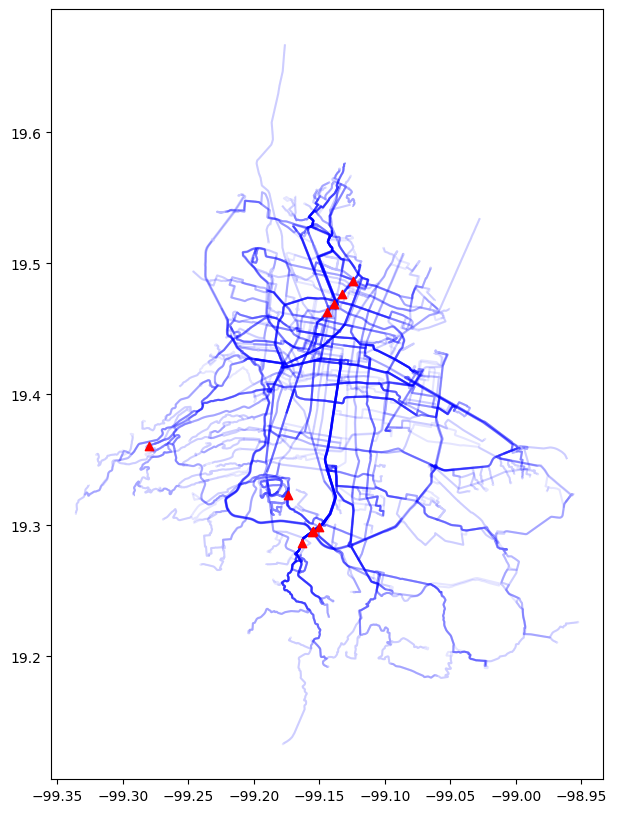

In [45]:
base_map = shapes_trips_df.plot(color = "blue", alpha=0.1, figsize=(10,10), zorder = 0)
busiests_stops_points.plot(ax = base_map, marker = "^", color = "red", zorder = 1)